In [16]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import pandas as pd
import itertools as it
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque
import cmath


from finite_groups import *

# from activation_funcs import *

In [17]:
# ==============================================================================
# HELPER: S4 DATA GENERATION
# ==============================================================================
def get_s4_data():
    """Generates S4 elements, classes, and characters for use in the main logic."""
    # 1. Elements
    perms = list(it.permutations(range(4)))
    
    # 2. Representatives & Classes (Manual definitions for standard S4)
    # 1A: Identity
    rep_1a = (0, 1, 2, 3) 
    # 2A: Transposition (0 1)
    rep_2a = (1, 0, 2, 3)
    # 3A: 3-Cycle (0 1 2)
    rep_3a = (1, 2, 0, 3)
    # 2B: Double Transposition (0 1)(2 3)
    rep_2b = (1, 0, 3, 2)
    # 4A: 4-Cycle (0 1 2 3)
    rep_4a = (1, 2, 3, 0)

    reps = [rep_1a, rep_2a, rep_3a, rep_2b, rep_4a]
    
    # 3. Character Table Rows (1, Sign, Deg2, Std, Std*Sign)
    # Cols: 1A, 2A, 3A, 2B, 4A
    chars = [
        [1,  1,  1,  1,  1], # Chi1 (Triv)
        [1, -1,  1,  1, -1], # Chi2 (Sign)
        [2,  0, -1,  2,  0], # Chi3 (Deg2)
        [3,  1,  0, -1, -1], # Chi4 (Std)
        [3, -1,  0, -1,  1]  # Chi5 (Std*Sign)
    ]
    
    return perms, reps, chars

# ==============================================================================
# SECTION 1: DEFINE GROUP (G = C2 x S4)
# ==============================================================================
def define_group():
    """
    Define G = C2 x S4.
    Elements are tuples (c, p) where c is int, p is tuple.
    """
    s4_perms, _, _ = get_s4_data()
    c2_elems = [1, -1]
    
    # Cross product
    elements = []
    for c in c2_elems:
        for p in s4_perms:
            elements.append((c, p))
            
    def mult_func(e1, e2):
        # e1 = (c1, p1), e2 = (c2, p2)
        c1, p1 = e1
        c2, p2 = e2
        
        # Multiply C2 part
        c_new = c1 * c2
        
        # Multiply S4 part: p_new[i] = p1[p2[i]]
        p_new = tuple(p1[x] for x in p2)
        
        return (c_new, p_new)

    return elements, mult_func

# ==============================================================================
# SECTION 2: DEFINE SUBGROUP (H)
# ==============================================================================
def define_subgroup(G: FiniteGroup):
    """
    Define H. We choose H isomorphic to S3 inside the S4 component, 
    and trivial inside C2.
    H = { (1, p) | p in S4, p(3) = 3 }
    Index = 48 / 6 = 8.
    """
    H = []
    
    # We can iterate G elements and check the condition
    for g in G.elements:
        c, p = g
        # Condition: C2 part is identity (1) AND S4 part fixes element 3
        if c == 1 and p[3] == 3:
            H.append(g)
            
    return H

# ==============================================================================
# SECTION 3: DEFINE CONJUGACY CLASSES (MANUAL)
# ==============================================================================
def define_conjugacy_classes():
    """
    Generate 10 classes for C2 x S4.
    Classes are (c_class) x (s4_class).
    """
    s4_perms, s4_reps, _ = get_s4_data()
    
    # Helper to find full class members in S4 for a rep
    # (We re-generate them simply to provide the full list to the solver)
    # Note: For S4, conjugation p * x * p_inv
    def get_class_members(rep):
        members = set()
        rep_inv = [0]*4
        for i, val in enumerate(rep): rep_inv[val] = i
        rep_inv = tuple(rep_inv)
        
        # Conjugate by all s4 perms
        for p in s4_perms:
            # p * rep * p^-1
            # calc p_inv
            p_inv = [0]*4
            for i, val in enumerate(p): p_inv[val] = i
            
            # rep * p_inv
            step1 = tuple(rep[x] for x in p_inv)
            # p * step1
            conj = tuple(p[x] for x in step1)
            members.add(conj)
        return list(members)

    classes = []
    
    # Iterate C2 components
    for c in [1, -1]:
        # Iterate S4 components
        for rep in s4_reps:
            full_rep = (c, rep)
            
            # Build members list
            s4_members = get_class_members(rep)
            full_members = [(c, m) for m in s4_members]
            
            classes.append( (full_rep, full_members) )
            
    return classes

# ==============================================================================
# SECTION 4: CHARACTER TABLE (C2 x S4)
# ==============================================================================
def define_character_table():
    """
    Generate 10x10 table via tensor product.
    Rows: (C2_char) x (S4_char)
    Cols: Classes generated in Section 3
    """
    _, s4_reps, s4_chars = get_s4_data()
    
    # C2 Chars: [1, 1] and [1, -1]
    c2_chars = [
        {1: 1, -1: 1},  # Trivial
        {1: 1, -1: -1}  # Sign
    ]
    
    char_map = {}
    labels = []
    
    # Loop over all combinations of characters
    idx = 1
    for c2_chi in c2_chars:
        for s4_chi_row in s4_chars:
            
            # This combination forms one row of the new table
            # We need to compute its value for every Representative defined in Sec 3
            
            for c_val in [1, -1]:
                for i, rep in enumerate(s4_reps):
                    full_rep = (c_val, rep)
                    
                    # Value = Chi_C2(c) * Chi_S4(p)
                    val = c2_chi[c_val] * s4_chi_row[i]
                    
                    if full_rep not in char_map:
                        char_map[full_rep] = []
                    
                    char_map[full_rep].append(val)
    
    # Generate labels
    # S4 labels
    s4_labels = ["1", "1111", "22", "31", "211"]
    c2_labels = ["+", "-"]
    
    for l1 in c2_labels:
        for l2 in s4_labels:
            labels.append(rf"${l2}^{l1}$")

    return char_map, labels

# ==============================================================================
# MAIN EXECUTION
# ==============================================================================
def run_analysis(activation_fn, verbose=False):
    
    if verbose: print(">>> 1. Loading Group Data (C2 x S4)...")
    elements, mult_func = define_group()
    classes_data = define_conjugacy_classes()
    
    G = FiniteGroup(elements, mult_func, classes=classes_data)
    if verbose: print(f"    Group Order: {G.n}")
    
    if verbose: print("\n>>> 2. Loading Subgroup Data...")
    # H = Stabilizer of '3' in S4 component, Trivial in C2 component
    H_elements = define_subgroup(G)
    solver = InducedRepSolver(G)
    solver.set_subgroup(H_elements)
    
    if verbose: print("\n>>> 3. Loading Character Table...")
    char_map, labels = define_character_table()
    solver.load_character_table(char_map, irrep_labels=labels)
    
    if verbose: print("\n>>> 4. Computing Exact Projectors (SymPy)...")
    solver.compute_projectors()
    
    if verbose: print("\n>>> 5. Induced Representation Decomposition:")
    for label, Q in solver.Qblocks.items():
        if Q.shape[1] > 0:
            if verbose: print(f"    Irrep '{label}' appears with dimension {Q.shape[1]}")
    
    if verbose: print("\n>>> 6. Building Interaction Graph...")
    
    graph = solver.build_interaction_graph(activation_fn=activation_fn, verbose=verbose)
    if verbose: print(f"    Edges found: {graph.edges()}")
    
    if len(graph.nodes) > 0:
        plt.figure(figsize=(6, 6))
        pos = nx.spring_layout(graph, seed=42)
        nx.draw_networkx(graph, pos, node_color="#E8F0FF", edgecolors="blue", 
                         node_size=1000, font_weight="bold", with_labels=True)
        plt.title(f"C2xS4 ({activation_fn.__name__})")
        plt.show()

>>> 1. Loading Group Data (C2 x S4)...
Building multiplication table for G (order 48)...
Using user-provided Conjugacy Classes.
    Group Order: 48

>>> 2. Loading Subgroup Data...
Computed 8 cosets for H (order 6) in G (order 48).

>>> 3. Loading Character Table...
Character table loaded (SymPy).

>>> 4. Computing Exact Projectors (SymPy)...

>>> 5. Induced Representation Decomposition:
    Irrep '$1^+$' appears with dimension 1
    Irrep '$31^+$' appears with dimension 3
    Irrep '$1^-$' appears with dimension 1
    Irrep '$31^-$' appears with dimension 3

>>> 6. Building Interaction Graph...
Irreps present: ['$1^+$', '$31^+$', '$1^-$', '$31^-$']
    Edges found: [('$1^+$', '$1^+$'), ('$31^+$', '$1^+$'), ('$31^+$', '$31^+$'), ('$1^-$', '$1^-$'), ('$31^-$', '$1^-$'), ('$31^-$', '$31^-$')]


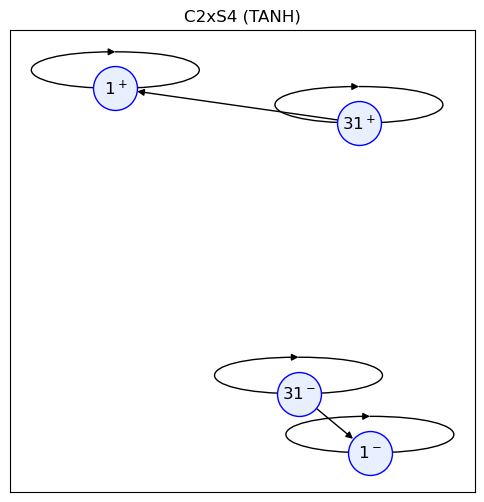

In [18]:
def RELU(x): return sp.Max(0, x)
def TANH(x): return sp.tanh(x)
def SIGMOID(x): return 1 / (1 + sp.exp(-x))
def LINEAR(x): return x

run_analysis(TANH, verbose=True)

In [37]:
# ============================================================
# 1. C2 part: permutation rep -> 1 ⊕ sign
# ============================================================

def c2_change_of_basis():
    """
    C2 = {0,1} acting by swap on basis f0, f1.
    Permutation basis: (f0, f1).
    Irrep basis: (u_+, u_-) where
        u_+ = f0 + f1   (trivial)
        u_- = f0 - f1   (sign)
    Returns Q_C2, Q_C2_inv where:
        v_old  = Q_C2 * v_new
        v_new  = Q_C2_inv * v_old
    """
    Q_C2 = sp.Matrix([[1,  1],
                      [1, -1]])        # columns = (u_+, u_-)
    Q_C2_inv = sp.Rational(1, 2) * Q_C2  # self-inverse up to factor 1/2
    return Q_C2, Q_C2_inv


# ============================================================
# 2. S4 part: permutation rep on {1,2,3,4} -> 1 ⊕ standard
# ============================================================

def s4_change_of_basis():
    """
    S4 acting on X = {1,2,3,4}.
    Permutation basis: (e1, e2, e3, e4).
    Irrep-adapted basis:
        t   = (1, 1, 1, 1)                  (trivial)
        w1  = (1, -1, 0, 0)
        w2  = (0, 1, -1, 0)
        w3  = (0, 0, 1, -1)                  (standard, sum=0)
    Returns Q_S4, Q_S4_inv where:
        v_old  = Q_S4 * v_new
        v_new  = Q_S4_inv * v_old
    """
    Q_S4 = sp.Matrix([
        [1,  1,  0,  0],   # t, w1, w2, w3
        [1, -1,  1,  0],
        [1,  0, -1,  1],
        [1,  0,  0, -1]
    ])
    Q_S4_inv = Q_S4.inv()  # exact rational inverse
    return Q_S4, Q_S4_inv


# ============================================================
# 3. Product action: C2 × S4 on X = C2 × {1,2,3,4}
#    Build Q_G = Q_C2 ⊗ Q_S4
# ============================================================

def product_change_of_basis():
    """
    Representation on V_G = Fun(C2 × {1,2,3,4}) ≅ R^8.

    Permutation basis ordering:
        (f0⊗e1, f0⊗e2, f0⊗e3, f0⊗e4,
         f1⊗e1, f1⊗e2, f1⊗e3, f1⊗e4)

    Irrep basis ordering (new basis):
        u_+⊗t,
        u_+⊗w1, u_+⊗w2, u_+⊗w3,
        u_-⊗t,
        u_-⊗w1, u_-⊗w2, u_-⊗w3

    So the blocks correspond to:
        0      : 1_C2 ⊗ 1_S4       (1-dim)
        1..3   : 1_C2 ⊗ χ^(3,1)    (3-dim)
        4      : sign_C2 ⊗ 1_S4    (1-dim)
        5..7   : sign_C2 ⊗ χ^(3,1) (3-dim)

    Returns Q_G, Q_G_inv where:
        v_old = Q_G * v_new
        v_new = Q_G_inv * v_old
    """
    Q_C2, Q_C2_inv = c2_change_of_basis()
    Q_S4, Q_S4_inv = s4_change_of_basis()

    # Kronecker product gives the product change-of-basis
    Q_G = sp.kronecker_product(Q_C2, Q_S4)
    Q_G_inv = sp.kronecker_product(Q_C2_inv, Q_S4_inv)

    return Q_G, Q_G_inv


# ============================================================
# 4. ReLU / piecewise-linear map in irrep basis
# ============================================================

def PL_irrep_coords(v_irrep,activation_fn):
    """
    Apply ReLU coordinate-wise in the irrep basis.
    v_irrep is an 8×1 column vector of coordinates in the irrep basis.
    """
    return sp.Matrix([activation_fn(x) for x in v_irrep])

def PL_equivariant(v_perm, activation_fn):
    """
    Full equivariant PL map on V_G in permutation coordinates:

        v_perm (old basis) -> v_irrep = Q_G_inv * v_perm
                             -> apply ReLU coordinate-wise in irrep basis
                             -> w_perm = Q_G * relu_irrep_coords(v_irrep)

    Returns w_perm in permutation coordinates.
    """
    Q_G, Q_G_inv = product_change_of_basis()
    v_irrep = Q_G_inv * v_perm
    w_irrep = PL_irrep_coords(v_irrep, activation_fn)
    w_perm = Q_G * w_irrep
    return w_perm


# ============================================================
# 5. Helpers to extract blocks corresponding to irreps
# ============================================================

def split_irrep_blocks(v_irrep):
    """
    Given v_irrep (8×1) in the irrep basis, split into the four irreducible
    subrepresentations:

        block_0: indices [0]      → 1 ⊗ 1        (dim 1)
        block_1: indices [1,2,3]  → 1 ⊗ χ^(3,1)  (dim 3)
        block_2: indices [4]      → sign ⊗ 1     (dim 1)
        block_3: indices [5,6,7]  → sign ⊗ χ^(3,1) (dim 3)
    """
    b0 = v_irrep[0:1, 0]   # 1-dim
    b1 = v_irrep[1:4, 0]   # 3-dim
    b2 = v_irrep[4:5, 0]   # 1-dim
    b3 = v_irrep[5:8, 0]   # 3-dim
    return b0, b1, b2, b3



In [52]:
Q_G

Matrix([
[1,  1,  0,  0,  1,  1,  0,  0],
[1, -1,  1,  0,  1, -1,  1,  0],
[1,  0, -1,  1,  1,  0, -1,  1],
[1,  0,  0, -1,  1,  0,  0, -1],
[1,  1,  0,  0, -1, -1,  0,  0],
[1, -1,  1,  0, -1,  1, -1,  0],
[1,  0, -1,  1, -1,  0,  1, -1],
[1,  0,  0, -1, -1,  0,  0,  1]])

In [65]:
sp.Matrix([1,0,0,0,0,0,0,0,0]).T

Matrix([[1, 0, 0, 0, 0, 0, 0, 0, 0]])

In [86]:
# Order: (c0⊗e1, c0⊗e2, c0⊗e3, c0⊗e4, c1⊗e1, c1⊗e2, c1⊗e3, c1⊗e4)
# v_perm = sp.Matrix([1, -2, 3, -4, 0, 5, -1, 2])
v_perm = sp.Matrix([0,0,0,0,0,1,5,7])

Q_G, Q_G_inv = product_change_of_basis()
# v_irrep = Q_G * v_perm
# w_irrep = PL_irrep_coords(v_irrep, RELU)
# w_perm = Q_G_inv * w_irrep

sp.Matrix([0,0,0,0,1,0,0,0]).T * Q_G_inv * (Q_G * v_perm).applyfunc(lambda x: RELU(x) + TANH(x))

Matrix([[-tanh(7)/4 + tanh(1)/4 + tanh(2)/4 + tanh(4)/4]])

In [39]:
QC2, QC2_inv = c2_change_of_basis()

In [40]:
P = sp.Matrix([
    [0, 1, 0, 0],  # e1 ↦ e2
    [0, 0, 1, 0],  # e2 ↦ e3
    [0, 0, 0, 1],  # e3 ↦ e4
    [1, 0, 0, 0],  # e4 ↦ e1
])
# 8×8 block-diagonal (direct sum) P ⊕ P
M = sp.diag(P, P)


In [41]:
Q_G_inv * M * Q_G

Matrix([
[1,  0, 0, 0, 0,  0, 0, 0],
[0, -1, 1, 0, 0,  0, 0, 0],
[0, -1, 0, 1, 0,  0, 0, 0],
[0, -1, 0, 0, 0,  0, 0, 0],
[0,  0, 0, 0, 1,  0, 0, 0],
[0,  0, 0, 0, 0, -1, 1, 0],
[0,  0, 0, 0, 0, -1, 0, 1],
[0,  0, 0, 0, 0, -1, 0, 0]])

In [50]:
Q_S4 = s4_change_of_basis()[0].T

def relu_matrix(M):
    return M.applyfunc(lambda x: sp.Max(0, x))

def tanh_matrix(M):
    return M.applyfunc(lambda x: sp.tanh(x))

tanh_matrix(Q_G * sp.diag(Q_S4, Q_S4))

Matrix([
[tanh(2),       0, tanh(1), tanh(1),  tanh(2),        0,  tanh(1),  tanh(1)],
[      0, tanh(3),       0, tanh(1),        0,  tanh(3),        0,  tanh(1)],
[tanh(1),       0, tanh(3),       0,  tanh(1),        0,  tanh(3),        0],
[tanh(1), tanh(1),       0, tanh(2),  tanh(1),  tanh(1),        0,  tanh(2)],
[tanh(2),       0, tanh(1), tanh(1), -tanh(2),        0, -tanh(1), -tanh(1)],
[      0, tanh(3),       0, tanh(1),        0, -tanh(3),        0, -tanh(1)],
[tanh(1),       0, tanh(3),       0, -tanh(1),        0, -tanh(3),        0],
[tanh(1), tanh(1),       0, tanh(2), -tanh(1), -tanh(1),        0, -tanh(2)]])